Còdecs: blosclz i zstd

CONCLUSIONS: no es solapen

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import aux_funcs

## Collect data from 3 different containers

30: entropy bitshuffle (split)

31: entropy shuffle (split)

32: entropy nofilter (split)

0: blosclz bitshuffle split

1: zstd bitshuffle split

In [168]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-bitshuffle', 'blosclz-bitshuffle-split', 'zstd-bitshuffle-split', 'entropy-shuffle', 'entropy-nofilter']
categories = ["30", "0", "1", "31", "32"]

df_entropy_bit = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_blosclz = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zstd = aux_funcs.get_df_by_category(paths, files[2], categories[2])
df_entropy_shuf = aux_funcs.get_df_by_category(paths, files[3], categories[3])
df_entropy_nof = aux_funcs.get_df_by_category(paths, files[4], categories[4])

# Filter data

Delete data corresponding to special values chunks.

In [169]:
df_bitshuffle = pd.concat([df_blosclz, df_zstd, df_entropy_bit, df_entropy_shuf, df_entropy_nof], axis=1)
df_bitshuffle = aux_funcs.delete_special_vals(df_bitshuffle, ["special_vals0", "special_vals1", "special_vals30"])
df_input_x = df_bitshuffle.loc[:, ['cratio30', 'speed30', 'cratio31', 'speed31', 'cratio32', 'speed32']]
df_input_x.head()

,cratio30,speed30,cratio31,speed31,cratio32,speed32
1,156.00,8.070000e+09,2.02,2.340000e+09,2.99,4.720000e+09
2,1.89,2.420000e+09,5.73,5.700000e+09,3.02,4.870000e+09
3,156.00,1.250000e+10,13100.00,5.410000e+09,3.01,4.850000e+09
5,156.00,8.460000e+09,2.11,2.700000e+09,3.09,4.810000e+09
6,1.87,2.450000e+09,6.10,6.340000e+09,3.53,5.260000e+09


## Compute best category

In [170]:
df_codecs = df_bitshuffle.loc[:, ['cratio0', 'speed0', 'cratio1', 'speed1']]
df_codecs.head()

,cratio0,speed0,cratio1,speed1
1,1.00,1.930000e+09,3.37,10500000.0
2,5.67,3.830000e+08,13.90,17700000.0
3,226.00,3.810000e+09,1870.00,65600000.0
5,1.00,1.940000e+09,3.34,10800000.0
6,6.34,4.580000e+08,14.90,19400000.0


### Normalize cratio and speed

In [171]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
all_cratios = np.concatenate((ncratio0, ncratio1), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio

In [172]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3]], axis=0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
all_speeds = np.concatenate((nspeed0, nspeed1), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed

### Compute score to determine which category is the best one

In [173]:
theta_balance = 0.6

df_score_balance = pd.DataFrame()
df_score_balance.insert(0, 0, theta_balance*ncratio0 + (1-theta_balance)*nspeed0)
df_score_balance.insert(1, 1, theta_balance*ncratio1 + (1-theta_balance)*nspeed1)

In [174]:
best_categ_bitshuffle = pd.DataFrame(df_score_balance.idxmax(axis=1), columns=['best_categ'])

In [175]:
categories = best_categ_bitshuffle['best_categ'].unique()
if len(categories) < 2:
    raise ValueError("Not enough categories in training data")

In [176]:
df_t = pd.concat([df_input_x['cratio30'], df_input_x['speed30'],
                  df_input_x['cratio31'], df_input_x['speed31'],
                  df_input_x['cratio32'], df_input_x['speed32'],
                  best_categ_bitshuffle['best_categ']], axis=1)
df_t.head()

,cratio30,speed30,cratio31,speed31,cratio32,speed32,best_categ
1,156.00,8.070000e+09,2.02,2.340000e+09,2.99,4.720000e+09,0
2,1.89,2.420000e+09,5.73,5.700000e+09,3.02,4.870000e+09,0
3,156.00,1.250000e+10,13100.00,5.410000e+09,3.01,4.850000e+09,1
5,156.00,8.460000e+09,2.11,2.700000e+09,3.09,4.810000e+09,0
6,1.87,2.450000e+09,6.10,6.340000e+09,3.53,5.260000e+09,0


## Split data into training and test

Create a balanced training data with same amount of samples for each (best) category

In [177]:
df_blc = pd.DataFrame()
# df_test = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]]))
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_blc = pd.concat([df_blc, df_i.head(n=nsamples)], axis=0)
    # df_test = pd.concat([df_test, df_i.iloc[nsamples:, :]], axis=0)

In [178]:
dftrain_x, dftest_x, dftrain_y, dftest_y = train_test_split(df_blc.drop(['best_categ'], axis=1),
                                                            df_blc['best_categ'],
                                                            test_size=0.1, shuffle=True)


## Normalize entropy data

then all entropies together

In [179]:
dfcratios = dftrain_x.iloc[:, [0, 2, 4]]
dfcratios = dfcratios.reset_index(drop=True)

In [180]:
mean_cratio = np.mean(dfcratios.mean())
dsv_cratio = np.std(dfcratios.std())

cratio30 = dfcratios["cratio30"]
cratio31 = dfcratios["cratio31"]
cratio32 = dfcratios["cratio32"]

cratio30 -= mean_cratio
cratio31 -= mean_cratio
cratio32 -= mean_cratio

# print(cratio30[:5])
# print(cratio31[:5])
# print(cratio32[:5])

cratio30 /= dsv_cratio
cratio31 /= dsv_cratio
cratio32 /= dsv_cratio

# print(cratio30[:5])
# print(cratio31[:5])
# print(cratio32[:5])

In [181]:
dfspeeds = dftrain_x.iloc[:, [1, 3, 5]]
dfspeeds = dfspeeds.reset_index(drop=True)

mean_speed = np.mean(dfspeeds.mean())
dsv_speed = np.std(dfspeeds.std())

speed30 = dfspeeds["speed30"]
speed31 = dfspeeds["speed31"]
speed32 = dfspeeds["speed32"]

speed30 -= mean_speed
speed31 -= mean_speed
speed32 -= mean_speed

speed30 /= dsv_speed
speed31 /= dsv_speed
speed32 /= dsv_speed

In [182]:
dftrain_x = pd.DataFrame()
dftrain_x = pd.concat([dftrain_x, cratio30, speed30,
                       cratio31, speed31,
                       cratio32, speed32], axis=1)

dftrain_x.head()

,cratio30,speed30,cratio31,speed31,cratio32,speed32
0,-0.753140,5.184399,4.199540,-0.760034,-0.812052,-2.168357
1,-0.812232,-2.823391,-0.811210,-1.259498,-0.811792,-1.619766
2,-0.812194,-3.175472,-0.810717,-0.661779,-0.811979,-2.266613
3,-0.753140,5.511916,4.199540,-0.882853,-0.812071,-2.233861
4,-0.753140,5.511916,4.199540,-0.841914,-0.811922,-1.726209


In [183]:
# Normalize test data with train statistics
cratio30_test = dftest_x["cratio30"]
cratio31_test = dftest_x["cratio31"]
cratio32_test = dftest_x["cratio32"]

cratio30_test -= mean_cratio
cratio31_test -= mean_cratio
cratio32_test -= mean_cratio
cratio30_test /= dsv_cratio
cratio31_test /= dsv_cratio
cratio32_test /= dsv_cratio

speed30_test = dftest_x["speed30"]
speed31_test = dftest_x["speed31"]
speed32_test = dftest_x["speed32"]

speed30_test -= mean_speed
speed31_test -= mean_speed
speed32_test -= mean_speed
speed30_test /= dsv_speed
speed31_test /= dsv_speed
speed32_test /= dsv_speed

dftest_x = pd.concat([cratio30_test, speed30_test,
                      cratio31_test, speed31_test,
                      cratio32_test, speed32_test], axis=1)
dftest_x.head()

,cratio30,speed30,cratio31,speed31,cratio32,speed32
19569,-0.753140,3.301176,-0.812435,-3.134533,-0.812140,-2.553190
5665,-0.753140,3.383055,-0.812343,-3.601244,-0.811911,-1.881780
11830,-0.812439,-2.856143,-0.811803,-2.545002,-0.812060,-2.782452
18927,-0.753140,5.430037,4.199540,-0.743659,-0.812117,-2.504062
7971,-0.776594,13.372323,-0.774834,13.617961,-0.810009,2.146679


# Neural Network with 2 categories

## Build model

In [184]:
from keras.utils import to_categorical
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)

In [185]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [186]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [187]:
history = model.fit(dftrain_x, dftrain_y, epochs=30, validation_split=0.1)

Epoch 1/30
633/633 [==============================] - 2s 2ms/step - loss: 0.0983 - acc: 0.9676 - val_loss: 0.0513 - val_acc: 0.9836

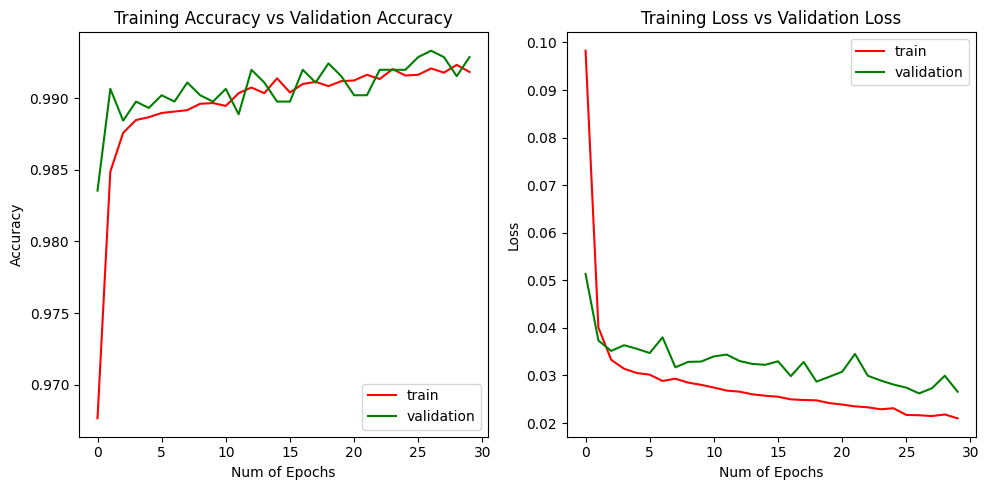

In [188]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch 5.

In [189]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=5, validation_split=0.1)

Epoch 1/5
633/633 [==============================] - 2s 2ms/step - loss: 0.0908 - acc: 0.9646 - val_loss: 0.0454 - val_acc: 0.9844

### Predict train data

In [190]:
y_hat = model.predict(x=dftrain_x)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(dftrain_y, axis=1)

703/703 [==============================] - 1s 2ms/step

In [191]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,11175,226
1,76,11014


In [192]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.986572406740474

### Predict test data

In [193]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

79/79 [==============================] - 0s 1ms/step


In [194]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
0,1233,32
1,11,1223


In [195]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score_balance = (len(aux) - fails) / len(aux)
score_balance

0.9827931172468988

## Cratio

In [196]:
theta_cratio = 0.9

df_score_cratio = pd.DataFrame()
df_score_cratio.insert(0, 0, theta_cratio*ncratio0 + (1-theta_cratio)*nspeed0)
df_score_cratio.insert(1, 1, theta_cratio*ncratio1 + (1-theta_cratio)*nspeed1)

In [197]:
best_categ_bitshuffle = pd.DataFrame(df_score_cratio.idxmax(axis=1), columns=['best_categ'])

categories = best_categ_bitshuffle['best_categ'].unique()
if len(categories) < 2:
    raise ValueError("Not enough categories in training data")

df_t['best_categ'] = best_categ_bitshuffle

In [198]:
df_cratio = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]]))
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_cratio = pd.concat([df_cratio, df_i.head(n=nsamples)], axis=0)

In [199]:
dftrain_x, dftest_x, dftrain_y, dftest_y = train_test_split(df_cratio.drop(['best_categ'], axis=1),
                                                            df_cratio['best_categ'],
                                                            test_size=0.1, shuffle=True)

In [209]:
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history_cratio = model.fit(dftrain_x, dftrain_y, epochs=30, validation_split=0.1)

Epoch 1/30
815/815 [==============================] - 3s 2ms/step - loss: 7789353.5000 - acc: 0.8311 - val_loss: 2443660.0000 - val_acc: 0.8657

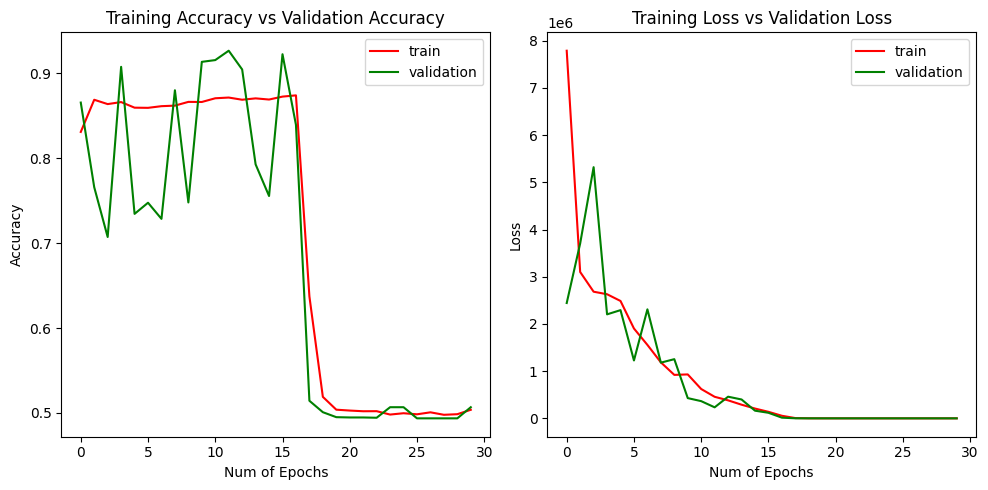

In [210]:

_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history_cratio.history['acc'], 'r')
ax[0].plot(history_cratio.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history_cratio.history['loss'], 'r')
ax[1].plot(history_cratio.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch 20.

In [211]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=20, validation_split=0.1)

Epoch 1/20
815/815 [==============================] - 2s 2ms/step - loss: 25928994.0000 - acc: 0.8454 - val_loss: 6905738.0000 - val_acc: 0.8854

### Predict train data

In [212]:
y_hat = model.predict(x=dftrain_x)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(dftrain_y, axis=1)

906/906 [==============================] - 1s 1ms/step

In [213]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,12939,964
1,1566,13493


In [214]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.9126441544092259

### Predict test data

In [215]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

101/101 [==============================] - 0s 2ms/step


In [216]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
0,1419,96
1,166,1537


In [217]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score_cratio = (len(aux) - fails) / len(aux)
score_cratio


0.9185829707893102

## SPEED

In [239]:
theta_speed = 0.4

df_score_speed= pd.DataFrame()
df_score_speed.insert(0, 0, theta_speed*ncratio0 + (1-theta_speed)*nspeed0)
df_score_speed.insert(1, 1, theta_speed*ncratio1 + (1-theta_speed)*nspeed1)

In [240]:
best_categ_bitshuffle = pd.DataFrame(df_score_speed.idxmax(axis=1), columns=['best_categ'])

categories = best_categ_bitshuffle['best_categ'].unique()
if len(categories) < 2:
    raise ValueError("Not enough categories in training data")

df_t['best_categ'] = best_categ_bitshuffle

In [241]:
df_speed = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]]))
print(nsamples)
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_speed = pd.concat([df_speed, df_i.head(n=nsamples)], axis=0)

600


In [242]:
dftrain_x, dftest_x, dftrain_y, dftest_y = train_test_split(df_speed.drop(['best_categ'], axis=1),
                                                            df_speed['best_categ'],
                                                            test_size=0.1, shuffle=True)

In [243]:
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history_speed = model.fit(dftrain_x, dftrain_y, epochs=30, validation_split=0.1)

Epoch 1/30
31/31 [==============================] - 1s 7ms/step - loss: 278655520.0000 - acc: 0.5195 - val_loss: 99477768.0000 - val_acc: 0.6852
Epoch 2/30
31/31 [==============================] - 0s 3ms/step - loss: 45476052.0000 - acc: 0.6800 - val_loss: 55682584.0000 - val_acc: 0.5926
Epoch 3/30
31/31 [==============================] - 0s 3ms/step - loss: 18047070.0000 - acc: 0.6409 - val_loss: 20263178.0000 - val_acc: 0.6389
Epoch 4/30
31/31 [==============================] - 0s 3ms/step - loss: 10646347.0000 - acc: 0.6852 - val_loss: 19149060.0000 - val_acc: 0.7130
Epoch 5/30
31/31 [==============================] - 0s 2ms/step - loss: 7736611.5000 - acc: 0.7428 - val_los

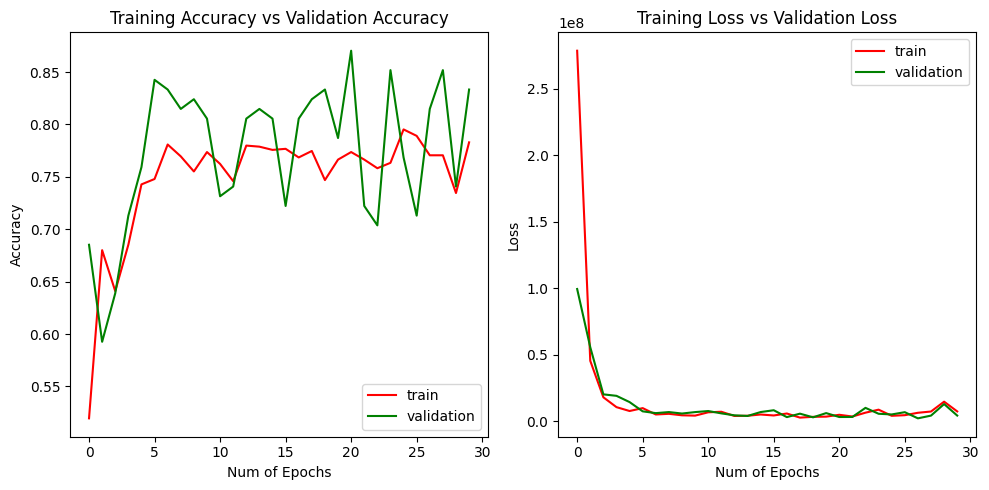

In [244]:

_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history_speed.history['acc'], 'r')
ax[0].plot(history_speed.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history_speed.history['loss'], 'r')
ax[1].plot(history_speed.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch 10.

In [245]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=10, validation_split=0.1)

Epoch 1/10
31/31 [==============================] - 2s 9ms/step - loss: 218342656.0000 - acc: 0.5782 - val_loss: 33545576.0000 - val_acc: 0.6944
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 30400944.0000 - acc: 0.6656 - val_loss: 14410263.0000 - val_acc: 0.7130
Epoch 3/10
31/31 [==============================] - 0s 2ms/step - loss: 11227616.0000 - acc: 0.7078 - val_loss: 9042274.0000 - val_acc: 0.6481
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 4094750.0000 - acc: 0.7582 - val_loss: 2883043.0000 - val_acc: 0.8056
Epoch 5/10
31/31 [==============================] - 0s 4ms/step - loss: 4251199.5000 - acc: 0.7377 - val_loss: 2728713.5000 - val_acc: 0.8333
Epoch 6/10
31/3

### Predict train data

In [246]:
y_hat = model.predict(x=dftrain_x)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(dftrain_y, axis=1)

34/34 [==============================] - 0s 1ms/step


In [247]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,512,186
1,28,354


In [248]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.8018518518518518

### Predict test data

In [249]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

4/4 [==============================] - 0s 3ms/step


In [250]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
0,55,23
1,5,37


In [251]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score_speed = (len(aux) - fails) / len(aux)
score_speed



0.7666666666666667